In [1]:
stocks=['MSFT','AAPL','NVDA','GOOGL','AMZN','META','LLY','AVGO','V','JPM','TSLA','WMT','XOM','UNH','MA','PG','JNJ','HD','ORCL','MRK','COST','ABBV','CVX','BAC','CRM','NFLX','KO','AMD','PEP','ADBE','TMO','DIS','WFC','MCD','CSCO','TMUS','ABT','QCOM','CAT','DHR','INTU','GE','IBM','VZ','AMAT','AXP','CMCSA','NOW','COP','INTC','TXN','UBER','BX','MS','PFE','NKE','AMGN','PM','UNP','RTX','ISRG','SPGI','GS','LOW','NEE','MU','SCHW','SYK','HON','PGR','UPS','LRCX','ELV','BKNG','T','BLK','C','DE','LMT','TJX','BA','ABNB','VRTX','BSX','ADP','PLD','CI','SBUX','REGN','MMC','BMY','ADI','PANW','MDLZ','KLAC','SCCO','FI','CVS','DELL','KKR','GILD','WM','HCA','ANET','SNPS','AMT','CMG','CDNS','SHW','GD','EOG','SO','TGT','CME','ITW','ICE','MPC','DUK','MO','SLB','FCX','CL','CRWD','ZTS','EQIX','PH','MCK','MAR','MCO','TDG','CTAS','WDAY','PSX','BDX','APH','NOC','CSX','PYPL','FDX','ORLY','EMR','ECL','PXD','USB','EPD','APO','PCAR','RSG','PNC','OXY','CEG','MRVL','MSI','MNST','ROP','SMCI','VLO','NSC','DASH','EW','COF','CPRT','COIN','DXCM','ET','WELL','APD','AZO','HLT','MMM','AJG','MET','SNOW','EL','AIG','FTNT','GM','CARR','DHI','COR','TFC','CTA-PA','TRV','STZ','F','GWW','NUE','HES','AFL','PSA','IBKR','ADSK','MCHP','SPG','WMB','ODFL','OKE','SQ','PLTR']
stocks=[i.replace('-','.') for i in stocks][0:2]

In [2]:
import pandas as pd
import vectorbt as vbt
import plotly
from order_routerv2 import *
import tensorflow as tf
from keras.models import load_model
from utils import*
from concurrent.futures import ThreadPoolExecutor,ProcessPoolExecutor
from datetime import*
import pickle as pkl
import vectorbt as vbt

import zigzag
import pandas_ta as pdt
from alpaca.data.historical import *
from alpaca.data.requests import *
from alpaca.data.timeframe import *
from alpaca.data.enums import *
from alpaca.trading.client import *
from alpaca.trading.requests import * 
from alpaca.trading.enums import *

with open('multi_scaler7.pkl','raaaaaaaaaaaaaaaaaaaaaaaaaaab') as f:
    multi_scaler=pkl.load(f)
from keras.models import load_model
with tf.device('/CPU:0'):
    model = load_model('model7.keras', compile=False)
    model.compile()


In [3]:
from scipy.signal import butter, filtfilt
def apply_butterworth_filter(df, order=7, cutoff=0.0001):
    b, a = butter(order, cutoff)
    filtered_data = filtfilt(b, a, df)
    return filtered_data


In [4]:
trader=Trader(model=load_model('model3.keras'),multi_scaler=multi_scaler,encoder=encoder)


In [5]:
def get_bars(time, stocks):
    request_params = StockBarsRequest(
        symbol_or_symbols=stocks,
        timeframe=TimeFrame(5, TimeFrameUnit('Min')),
        start=datetime(2016,1,1),
        adjustment=Adjustment.ALL,
        feed='sip'
    )
    print(stocks)
    return trader.client.get_stock_bars(request_params).df.drop(columns=['vwap'])


In [6]:
def get_bars_multi(symbol_or_symbols, time):
    with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
        tasks = [pool.apply_async(get_bars, (time, symbol)) for symbol in symbol_or_symbols]
        bars = {symbol: task.get() for symbol, task in zip(symbol_or_symbols, tasks)}
    return bars


In [8]:
barset=get_bars_multi(stocks, datetime.now(timezone.utc))


AAPLMSFT



In [16]:
def process_data(symbol):
    print(symbol)
    df = barset[symbol].loc[symbol].between_time('13:30','20:00').copy()  # Access the DataFrame for the symbol
    df['close_fft'] = apply_butterworth_filter(df['close'], cutoff=0.2, order=4)
    df['close_ma12'] = df['close'].rolling(12, center=False).mean()
    df['close_ma25'] = df['close'].rolling(25, center=False).mean()
    df['close_ma50'] = df['close'].rolling(50, center=False).mean()
    df['close_ma100'] = df['close'].rolling(100, center=False).mean()

    df['close_ma12_osc'] = df['close_ma12'].pct_change().bfill()
    df['close_ma25_osc'] = df['close_ma25'].pct_change().bfill()
    df['close_ma50_osc'] = df['close_ma50'].pct_change().bfill()
    df['close_ma100_osc'] = df['close_ma100'].pct_change().bfill()

    df['min'] = df['close'].index.minute
    df['day'] = df['close'].index.day
    df['symbol'] = symbol

    df = df.dropna()
    df['zigzag'] = zigzag.peak_valley_pivots(df['close_fft'], 0.03, -0.03)
    df['zigzag'] = df['zigzag'].replace(0, np.nan).ffill()

    bb = pdt.bbands(open_=df['open'], high=df['high'], low=df['low'], close=df['close'], length=100)
    bbb = bb['BBB_100_2.0']
    bbp = bb['BBP_100_2.0']
    trend = pdt.supertrend(open_=df['open'], high=df['high'], low=df['low'], close=df['close'], length=100, atr_length=100)['SUPERTd_100_3.0']
    rsx = pdt.rsx(open_=df['open'], high=df['high'], low=df['low'], close=df['close'], length=100)
    
    df = pd.concat([rsx, bbb, bbp, df, trend], axis=1)
    
    return df.dropna()
x=process_data('AAPL')

AAPL


In [18]:

x_,y_=window_array(multi_scaler.transform(x)[['close_ma100_osc','close_ma50_osc','close_ma25_osc','close_ma12_osc','trade_count','BBB_100_2.0','BBP_100_2.0','SUPERTd_100_3.0','RSX_100','day']].values,y=np.ones((x.shape[0])),window_row_length=16*3)


In [24]:
res=model.predict(x_,batch_size=10000)

17/17 [==============================] - 13s 776ms/step


In [25]:
x

,RSX_100,BBB_100_2.0,BBP_100_2.0,open,high,low,close,volume,trade_count,close_fft,...,close_ma100,close_ma12_osc,close_ma25_osc,close_ma50_osc,close_ma100_osc,min,day,symbol,zigzag,SUPERTd_100_3.0
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-06 16:50:00+00:00,0.000000,4.941094,0.263058,23.010,23.04,23.01,23.020,1260572.0,2370.0,23.001864,...,23.292700,0.000036,-0.000104,-0.000407,-0.000245,50,6,AAPL,1.0,1
2016-01-06 16:55:00+00:00,50.000000,4.940255,0.216617,23.020,23.03,22.96,22.960,2319920.0,3971.0,22.987230,...,23.286000,-0.000289,-0.000052,-0.000503,-0.000288,55,6,AAPL,1.0,1
2016-01-06 17:00:00+00:00,50.000000,4.928710,0.239142,22.970,22.99,22.96,22.980,1923584.0,3087.0,22.973020,...,23.279300,-0.000686,-0.000069,-0.000451,-0.000288,0,6,AAPL,1.0,1
2016-01-06 17:05:00+00:00,50.000000,4.917048,0.252783,22.980,23.00,22.96,22.990,2724176.0,3148.0,22.957805,...,23.272900,-0.000434,0.000035,-0.000408,-0.000275,5,6,AAPL,1.0,1
2016-01-06 17:10:00+00:00,50.000000,4.901907,0.240373,22.990,22.99,22.96,22.970,1591796.0,2777.0,22.941334,...,23.266100,-0.000506,-0.000243,-0.000391,-0.000292,10,6,AAPL,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-08 19:40:00+00:00,52.517216,0.658755,0.923477,182.945,183.04,182.86,182.910,959240.0,8918.0,182.914234,...,182.401160,0.000007,0.000101,0.000072,0.000012,40,8,AAPL,-1.0,1
2024-05-08 19:45:00+00:00,52.680197,0.656088,0.829803,182.905,182.91,182.69,182.795,618329.0,6799.0,182.882838,...,182.400323,-0.000043,0.000069,0.000076,-0.000005,45,8,AAPL,-1.0,1
2024-05-08 19:50:00+00:00,52.844402,0.664015,0.922459,182.800,183.07,182.72,182.915,1282387.0,13510.0,182.830872,...,182.403323,0.000007,0.000094,0.000110,0.000016,50,8,AAPL,-1.0,1


/tmp/ipykernel_720/1049164405.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  init_cash=close_prices[0]*1,


Total Profit: close    148.536157
Name: total_profit, dtype: float64


/tmp/ipykernel_720/1049164405.py:47: UserWarning: Object has multiple columns. Aggregating using <function mean at 0x7f2308691940>. Pass column to select a single column/group.
  stats = portfolio.stats()


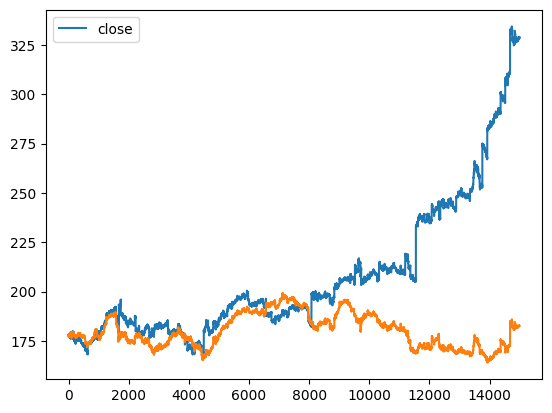

In [30]:

close_prices = x[16*3:]['close'][-15000:]

import numpy as np
import pandas as pd
import vectorbt as vbt
y_pred=np.where(res<0,1,0)[-15000:]

# Assuming y_pred is your prediction array or series
# Define your stop-loss and take-profit thresholds
stop_loss = -.01 # 2% stop loss
take_profit = .05  # 5% take profit


long_entries = y_pred== 1
long_exits = y_pred == 0  # Assuming you exit long when you want to go short

# Short signals
short_entries = y_pred == 0
short_exits =y_pred == 1  # Assuming you exit short when you want to go long

sl_stop = 0.01  # Stop loss of 1%
tp_stop = 0.05  # Take profit of 5%

# Create the portfolio
portfolio = vbt.Portfolio.from_signals(
    close_prices,
    entries=long_entries,
    exits=long_exits,
    short_entries=short_entries,
    short_exits=short_exits,
    #sl_stop=sl_stop,
    #tp_stop=tp_stop,
    #slippage=1.1,
    init_cash=close_prices[0]*1,
    freq='5min'
)


# Display the total profit
print("Total Profit:", portfolio.total_profit())

# Plot asset value
portfolio.asset_value().abs().reset_index(drop=True)[:].plot(),close_prices.reset_index(drop=True)[:].plot()


# Get statistics
stats = portfolio.stats()
